# Example: Decaying Turbulence

In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np

## Setup
The dimension of DecayingTurbulence vortex is defined by the stencil. Here the flow is two dimensional due to D2Q9. Special Inputs & standard values that can be set in the flow constructor are ...
* the wavenumber_energy-peak k0 (= 20 as default) 
* the initial_energy (= 0.5 as default)

In [2]:
context = lt.Context()
flow = lt.DecayingTurbulence(context=context, resolution=256,
                             reynolds_number=10000, mach_number=0.05, k0=20,
                             ic_energy=0.5, stencil=lt.D2Q9())
energyreporter = lt.ObservableReporter(lt.EnergySpectrum(flow), interval=500, 
                                       out=None)
simulation = lt.Simulation(flow=flow,
                           collision=lt.BGKCollision(flow.units.relaxation_parameter_lu),
                           reporter=[energyreporter])

steps     time     EnergySpectrum
Could not resolve cuda_native extension.
Installing Native module (/tmp/tmpwxw54zzz) ...


### Initialized flow
The initialized velocity is randomly generated and depends on the wavenumber peak k0, the initial energy, which are given in the flow constructor, and a given energy spectrum.

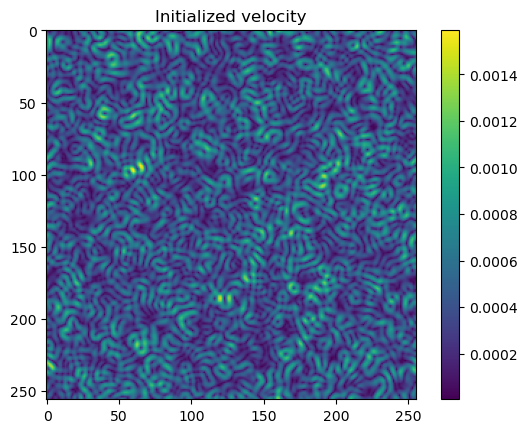

In [3]:
u = context.convert_to_ndarray(flow.u_pu)
u_norm = np.linalg.norm(u, axis=0)
plt.imshow(u_norm)
plt.colorbar()
plt.title('Initialized velocity')
plt.show()

### Energy spectrum
The energy spectrum, which is forced in the beginning is given with:

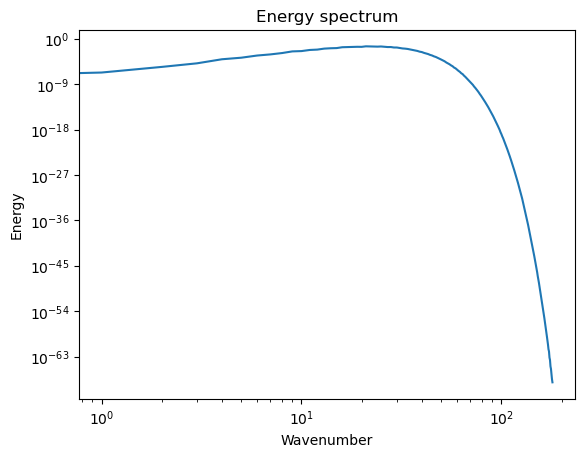

In [4]:
spectrum = flow.energy_spectrum
plt.loglog(spectrum[1],spectrum[0])
plt.title('Energy spectrum')
plt.xlabel('Wavenumber')
plt.ylabel('Energy')
plt.show()

## Run simulation
Before the simulation is executed, the pressure field is obtained by solving the pressure poisson equation. In addition, f_neq is initialized to obtain stress tensor at the start of the simulation.

In [5]:
mlups = simulation(num_steps=15000)
print("Performance in MLUPS:", mlups)

Performance in MLUPS: 355.44468658802873


### Velocity
* Velocity field after the simulation

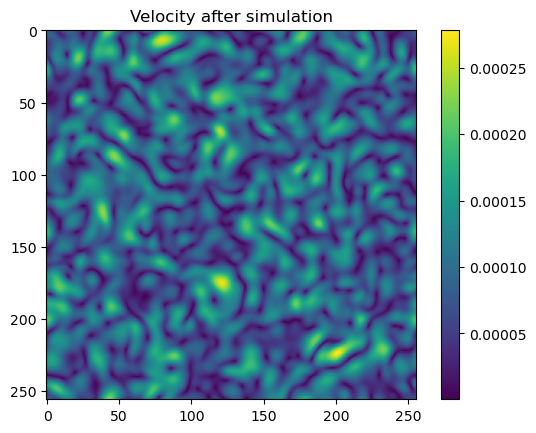

In [6]:
u = context.convert_to_ndarray(flow.u_pu)
u_norm = np.linalg.norm(u, axis=0)
plt.imshow(u_norm)
plt.colorbar()
plt.title('Velocity after simulation')
plt.show()

### Vorticity
* Vorticity field after the simulation

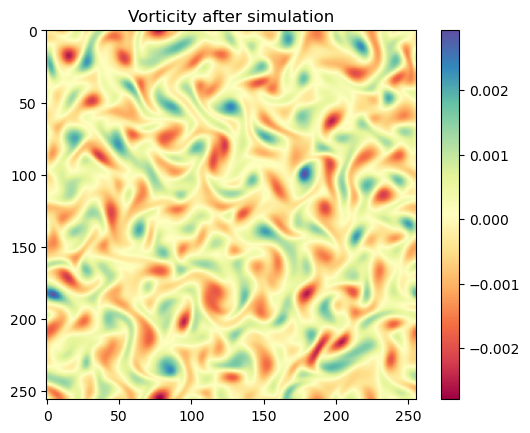

In [7]:
dx = flow.units.convert_length_to_pu(1.0)
grad_u0 = np.gradient(u[0], dx)
grad_u1 = np.gradient(u[1], dx)
vorticity = (grad_u1[0] - grad_u0[1])
plt.imshow(vorticity, cmap='Spectral')
plt.colorbar()
plt.title('Vorticity after simulation')
plt.show()

### Energy spectrum after simulation

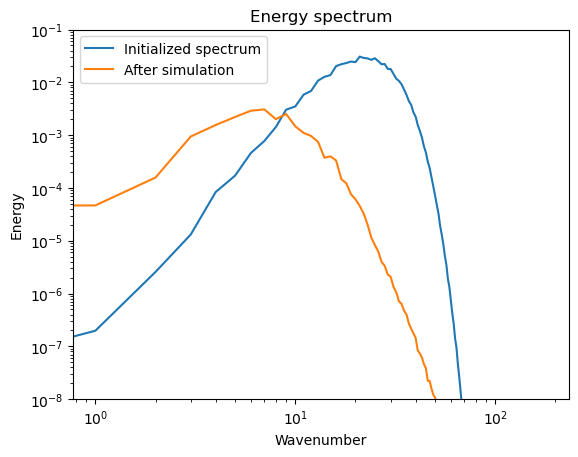

In [8]:
spectrum_final = simulation.reporter[0].out[-1]
plt.loglog(spectrum[1],spectrum[0],label='Initialized spectrum')
plt.loglog(spectrum[1],spectrum_final[2:],label='After simulation')
plt.title('Energy spectrum')
plt.xlabel('Wavenumber')
plt.ylabel('Energy')
plt.ylim(top=1e-1, bottom=1e-8)
plt.legend()
plt.show()